
# Phân tích doanh thu và hiệu suất bán hàng
- Tổng doanh thu theo ngày, tuần, tháng, xác định ngày nào trong tuần bán chạy nhất của tất cả cửa hàng và của từng cửa hàng.
- So sánh hiệu suất bán hàng của từng cửa hàng
- Phân tích tác động của giảm giá (số lượng bán ra và doanh thu trước và sau giảm giá)

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import sys
import os
sys.path.append('../../../scripts/')
import data_cleaning

# 1. Import data
Nhập dữ liệu đã qua xử lý, 20240722

In [68]:
df_menuitem = pd.read_csv("../../../data/processed/20240722/2.menuitem_20240722.csv")

In [69]:
df_menuitem.head()

,MD5KEY_MENUITEM,MD5KEY_ORDERSALE,CategoryDescription,DepartmentDescription,Description,StoreNumber,TaxAmount,AdjustedPrice,DiscountAmount,Price,Quantity,PLU,Id,date,SalesAmount,day_of_week
0,001E0224E4EDA63D6FED96D59E0C1E76,072D3B76BE58E4553A373AF3206D2CA5,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0.6975,7.75,0.00,7.75,1,111000041,326,2015-03-05,7.75,Thursday
1,003E4E20196B2F5BDD33CE06D2943EF4,14811D4F3458058007B0B6908C2DA393,Fountain,Fountain Drink 21 oz.,21oz Fountain Drink,46673,0.1530,1.70,0.00,1.70,1,212000126,280,2015-03-05,1.70,Thursday
2,012A55E5551C95A559A7B074AE85117E,22FA6C39B7A15ABB6EB568E66A6B30E1,6 Inch,6 Inch Sub,B.M.T. 6 inch,12631,0.3230,3.64,0.61,4.25,1,121000008,8,2015-03-05,3.64,Thursday
3,01B07F1C6DC6945796571FC78735DA16,915B69612845BBD974C39AC105F5CA8C,6 Inch,6 Inch Sub,Veggie Delite 6 inch,12631,0.3328,3.75,0.00,3.75,1,121000001,91,2015-03-05,3.75,Thursday
4,02DE19974DE5304BF243A1C2EC639495,CD6386C802450EDCF13A3D112D1F86EC,Add On,Add On 6in Portion,Avocado Add6in,12631,0.0443,0.50,0.00,0.50,1,175000062,564,2015-03-05,0.50,Thursday


In [70]:
df_ordersale = pd.read_csv("../../../data/processed/20240722/1.pos_ordersale_20240722.csv")

In [71]:
df_ordersale.head()

,MD5KEY_ORDERSALE,ChangeReceived,OrderNumber,TaxAmount,MealLocation,TransactionId,StoreNumber,date
0,00BCB738A1F814DB960C25012E9913DF,0.00,67,0.56,0,67,46673,2015-03-05
1,03438C257BC2DD0037F35EC8BFC0C8E2,3.46,39,0.54,0,39,12631,2015-03-05
2,04AEF56CF3130AC1EFAD41C470F5245D,0.00,81,0.69,0,79,46673,2015-03-05
3,04BBFAD4E73C30EE2EC3B4E52509637C,0.00,159,1.16,0,159,12631,2015-03-05
4,061AE382DC127057E8ADBBF869CFB361,0.00,51,0.00,0,51,12631,2015-03-05


# 2. Phân tích doanh thu ngày và ngày trong tuần
Phân tích doanh thu thao ngày, ngày trong tuần để hiểu rõ hơn về xu hướng doanh thu của tổng quan và của từng cửa hàng.

## 2.1 Doanh thu tổng
Để phân tích doanh cần các trường trong file menuitem:
- SalesAmount
- date
- day_of_week

### 2.1.1 Tách outliers Quantity

In [72]:
# Tính Q1_quantity (25th percentile) và Q3_Quantity (75th percentile)
Q1_quantity = df_menuitem['Quantity'].quantile(0.25)
Q3_quantity = df_menuitem['Quantity'].quantile(0.75)

# Tính IQR_quantity
IQR_quantity = Q3_quantity - Q1_quantity

# Xác định giới hạn dưới và trên
lower_bound_quantity = Q1_quantity - 1.5 * IQR_quantity
upper_bound_quantity = Q3_quantity + 1.5 * IQR_quantity

# Xác định giá trị ngoại lai
outliers_quantity = df_menuitem[(df_menuitem['Quantity'] < lower_bound_quantity) | (df_menuitem['Quantity'] > upper_bound_quantity)].copy()
non_outliers_quantity = df_menuitem[~((df_menuitem['Quantity'] < lower_bound_quantity) | (df_menuitem['Quantity'] > upper_bound_quantity))].copy()

In [73]:
print("Số hàng menuitem:", df_menuitem.shape[0])
print("Tổng hàng outliers và non_outliers:", outliers_quantity.shape[0] + non_outliers_quantity.shape[0])
print("% outliers:", outliers_quantity.shape[0] / df_menuitem.shape[0] * 100)
print("Số hàng outliers:", outliers_quantity.shape[0])
print("Số hàng non_outliers:", non_outliers_quantity.shape[0])

Số hàng menuitem: 91420
Tổng hàng outliers và non_outliers: 91420
% outliers: 7.5082038941150735
Số hàng outliers: 6864
Số hàng non_outliers: 84556


### 2.1.2 Doanh thu tổng non_outliers

In [74]:
# Doanh thu tổng theo ngày
revenue_by_day = non_outliers_quantity.groupby(['date', 'day_of_week']).agg(revenue=('SalesAmount', 'sum')).reset_index()

# Doanh thu tổng ngày trong tuần
revenue_day_of_week = non_outliers_quantity.groupby('day_of_week').agg(revenue=('SalesAmount', 'sum')).sort_values(by='revenue').reset_index()


In [75]:
revenue_by_day

,date,day_of_week,revenue
0,2015-03-05,Thursday,1246.79
1,2015-03-06,Friday,1023.68
2,2015-03-07,Saturday,834.16
3,2015-03-08,Sunday,1338.52
4,2015-03-09,Monday,1183.01
...,...,...,...
98,2015-06-11,Thursday,3693.93
99,2015-06-12,Friday,2594.26
100,2015-06-13,Saturday,2362.31
101,2015-06-14,Sunday,2827.45


In [76]:
revenue_day_of_week

,day_of_week,revenue
0,Saturday,29249.54
1,Friday,36345.89
2,Tuesday,42627.96
3,Thursday,43829.93
4,Wednesday,44715.46
5,Sunday,44953.00
6,Monday,45028.46


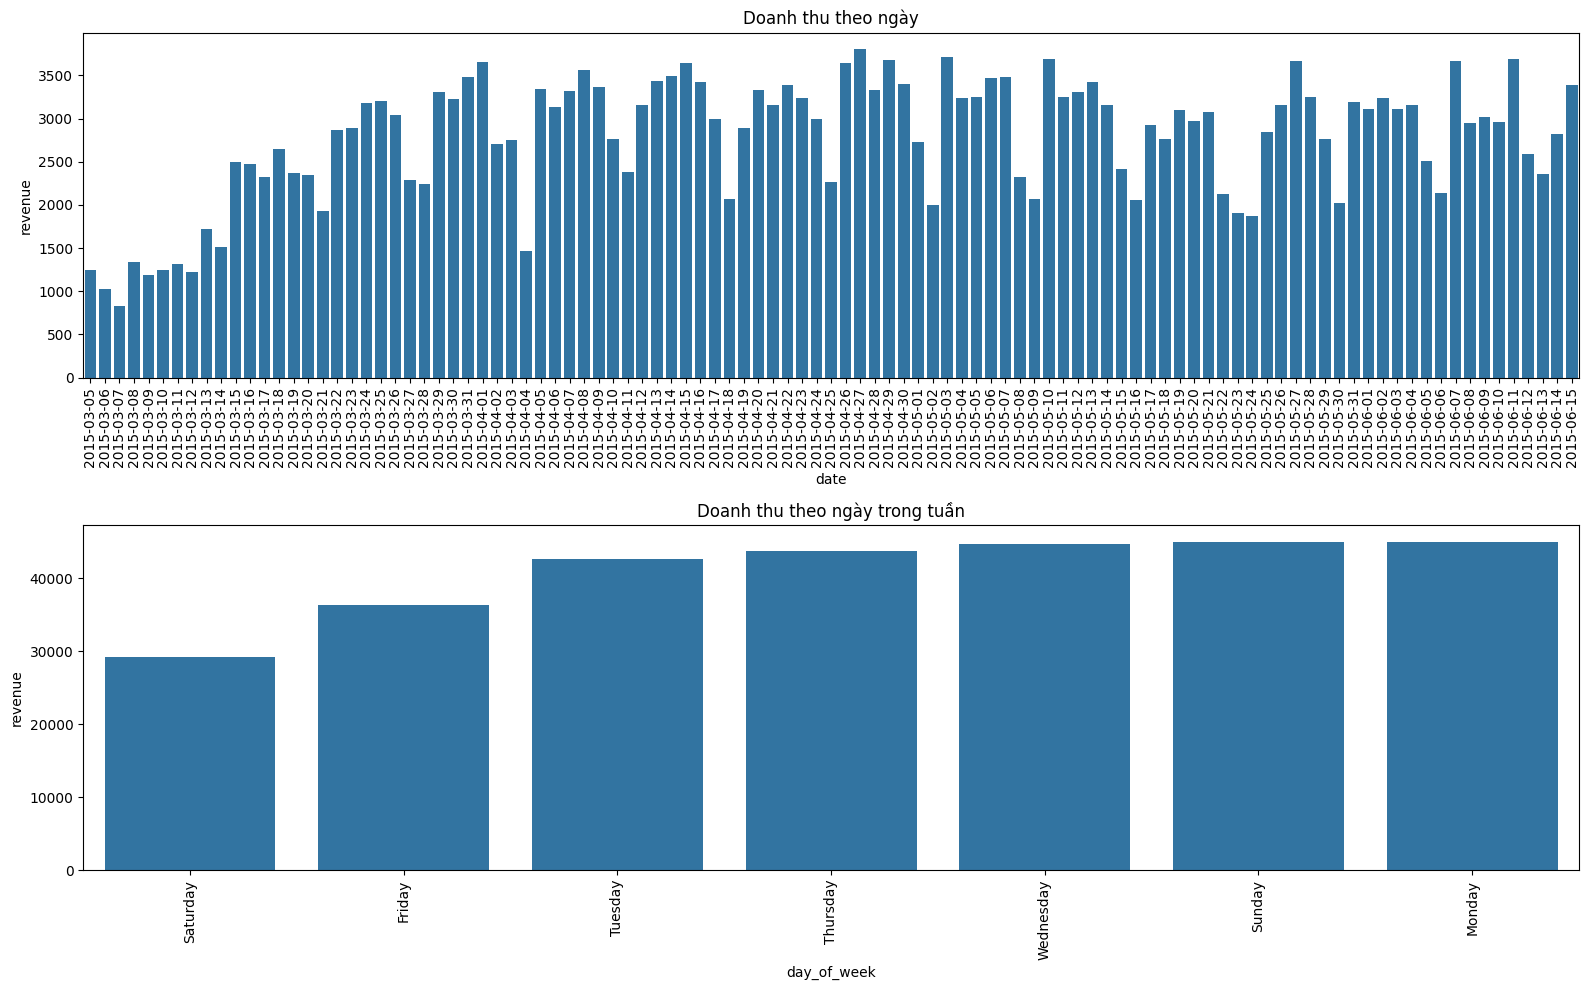

In [77]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(data=revenue_by_day,
             x='date',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=revenue_day_of_week,
             x='day_of_week',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày trong tuần")

plt.tight_layout()
plt.show()

### 2.1.3 Doanh thu tổng outliers

In [78]:
# Doanh thu tổng theo ngày
revenue_by_day_outliers = outliers_quantity.groupby(['date', 'day_of_week']).agg(revenue=('SalesAmount', 'sum')).reset_index()

# Doanh thu tổng ngày trong tuần
revenue_day_of_week_outliers = outliers_quantity.groupby('day_of_week').agg(revenue=('SalesAmount', 'sum')).sort_values(by='revenue').reset_index()


In [79]:
revenue_by_day_outliers

,date,day_of_week,revenue
0,2015-03-05,Thursday,312.00
1,2015-03-06,Friday,404.60
2,2015-03-07,Saturday,201.45
3,2015-03-08,Sunday,435.66
4,2015-03-09,Monday,257.48
...,...,...,...
98,2015-06-11,Thursday,907.29
99,2015-06-12,Friday,1081.70
100,2015-06-13,Saturday,602.72
101,2015-06-14,Sunday,664.09


In [80]:
revenue_day_of_week_outliers

,day_of_week,revenue
0,Sunday,8250.29
1,Tuesday,9458.58
2,Wednesday,9553.10
3,Monday,10140.98
4,Friday,12123.43
5,Thursday,12206.03
6,Saturday,74124.92


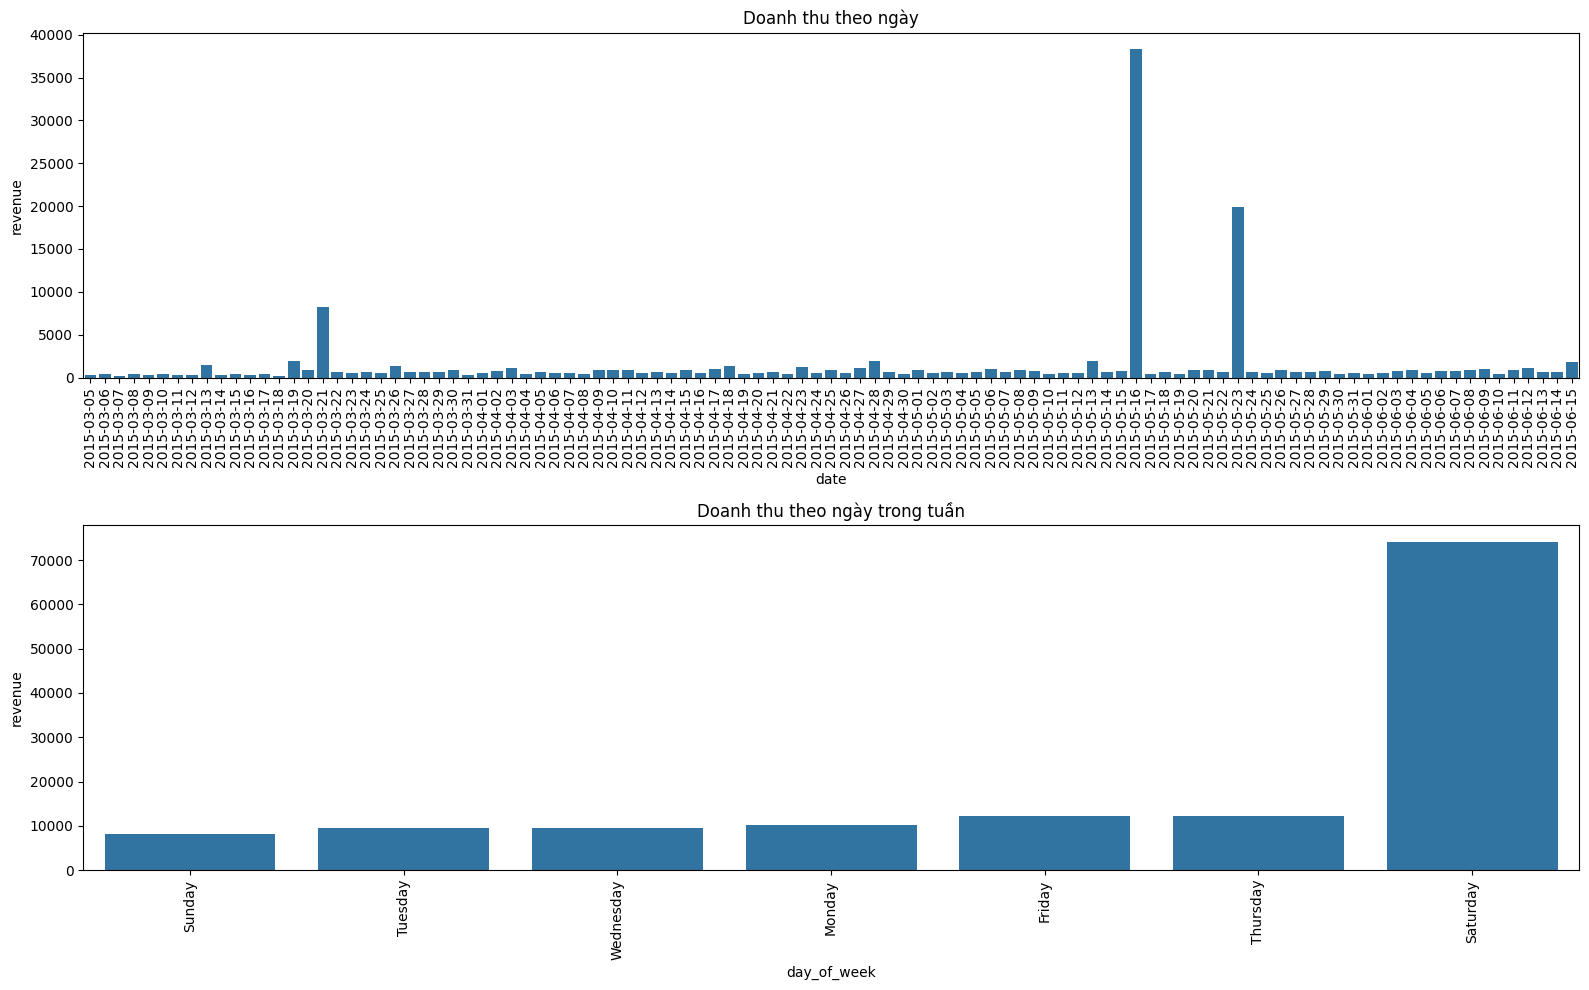

In [81]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(data=revenue_by_day_outliers,
             x='date',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=revenue_day_of_week_outliers,
             x='day_of_week',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày trong tuần")

plt.tight_layout()
plt.show()

## 2.2 Doanh thu trung bình mỗi đơn hàng

### 2.2.1 Doanh thu đơn hàng non_outliers

In [84]:
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week'],
      dtype='object')

In [97]:
group_by_day = non_outliers_quantity.groupby('date').agg(
  total_order=('MD5KEY_ORDERSALE', 'nunique'),
  total_item=('Quantity', 'sum'),
  total_revenue=('SalesAmount', 'sum')).reset_index()

group_by_day['avg_item_order'] = group_by_day['total_item'] / group_by_day['total_order']
group_by_day['avg_revenue_order'] = group_by_day['total_revenue'] / group_by_day['total_order']

group_by_day

,date,total_order,total_item,total_revenue,avg_item_order,avg_revenue_order
0,2015-03-05,170,366,1246.79,2.152941,7.334059
1,2015-03-06,133,298,1023.68,2.240602,7.696842
2,2015-03-07,108,248,834.16,2.296296,7.723704
3,2015-03-08,182,392,1338.52,2.153846,7.354505
4,2015-03-09,157,371,1183.01,2.363057,7.535096
...,...,...,...,...,...,...
98,2015-06-11,454,1074,3693.93,2.365639,8.136410
99,2015-06-12,354,736,2594.26,2.079096,7.328418
100,2015-06-13,282,660,2362.31,2.340426,8.376986
101,2015-06-14,409,829,2827.45,2.026895,6.913081


In [103]:
print(group_by_day['total_revenue'].min())
print(group_by_day['total_revenue'].max())

834.16
3803.73


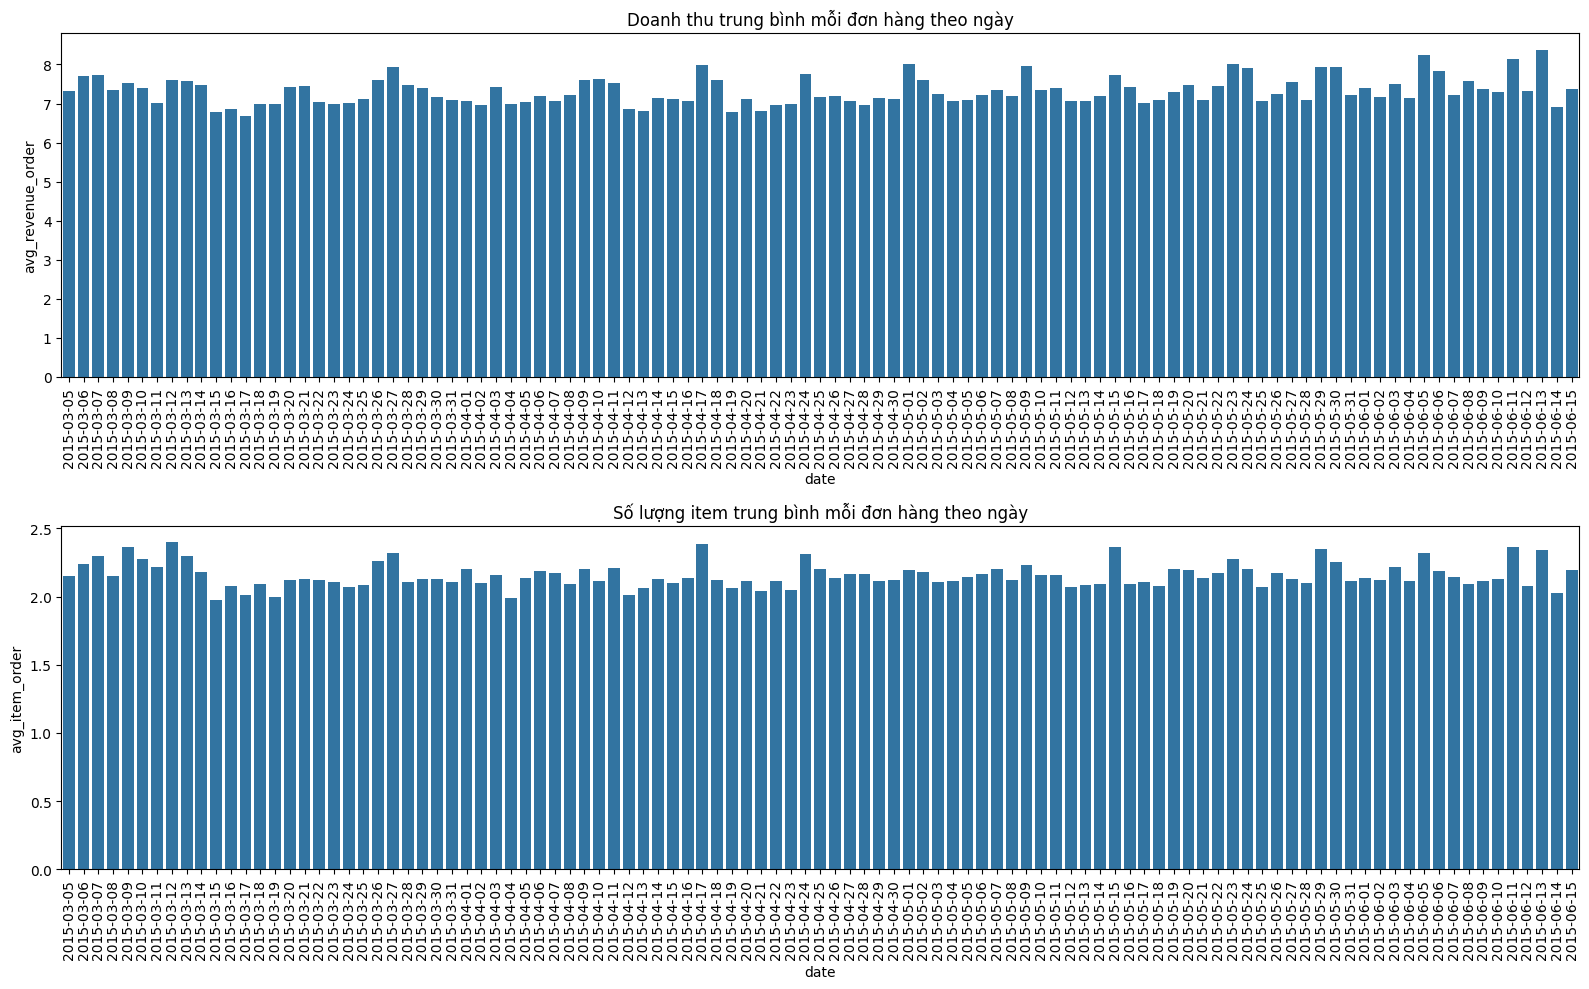

In [98]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(data=group_by_day,
             x='date',
             y='avg_revenue_order')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu trung bình mỗi đơn hàng theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=group_by_day,
             x='date',
             y='avg_item_order')
plt.xticks(rotation=90, ha='center')
plt.title("Số lượng item trung bình mỗi đơn hàng theo ngày")

plt.tight_layout()
plt.show()

### 2.2.2 Doanh thu đơn hàng outliers

In [99]:
group_by_day_outliers = outliers_quantity.groupby('date').agg(
  total_order=('MD5KEY_ORDERSALE', 'nunique'),
  total_item=('Quantity', 'sum'),
  total_revenue=('SalesAmount', 'sum')).reset_index()

group_by_day_outliers['avg_item_order'] = group_by_day_outliers['total_item'] / group_by_day_outliers['total_order']
group_by_day_outliers['avg_revenue_order'] = group_by_day_outliers['total_revenue'] / group_by_day_outliers['total_order']

group_by_day_outliers

,date,total_order,total_item,total_revenue,avg_item_order,avg_revenue_order
0,2015-03-05,32,78,312.00,2.437500,9.750000
1,2015-03-06,26,69,404.60,2.653846,15.561538
2,2015-03-07,24,54,201.45,2.250000,8.393750
3,2015-03-08,37,95,435.66,2.567568,11.774595
4,2015-03-09,27,66,257.48,2.444444,9.536296
...,...,...,...,...,...,...
98,2015-06-11,69,181,907.29,2.623188,13.149130
99,2015-06-12,72,220,1081.70,3.055556,15.023611
100,2015-06-13,54,146,602.72,2.703704,11.161481
101,2015-06-14,58,138,664.09,2.379310,11.449828


In [102]:
print(group_by_day_outliers['total_revenue'].min())
print(group_by_day_outliers['total_revenue'].max())

201.45000000000002
38310.49


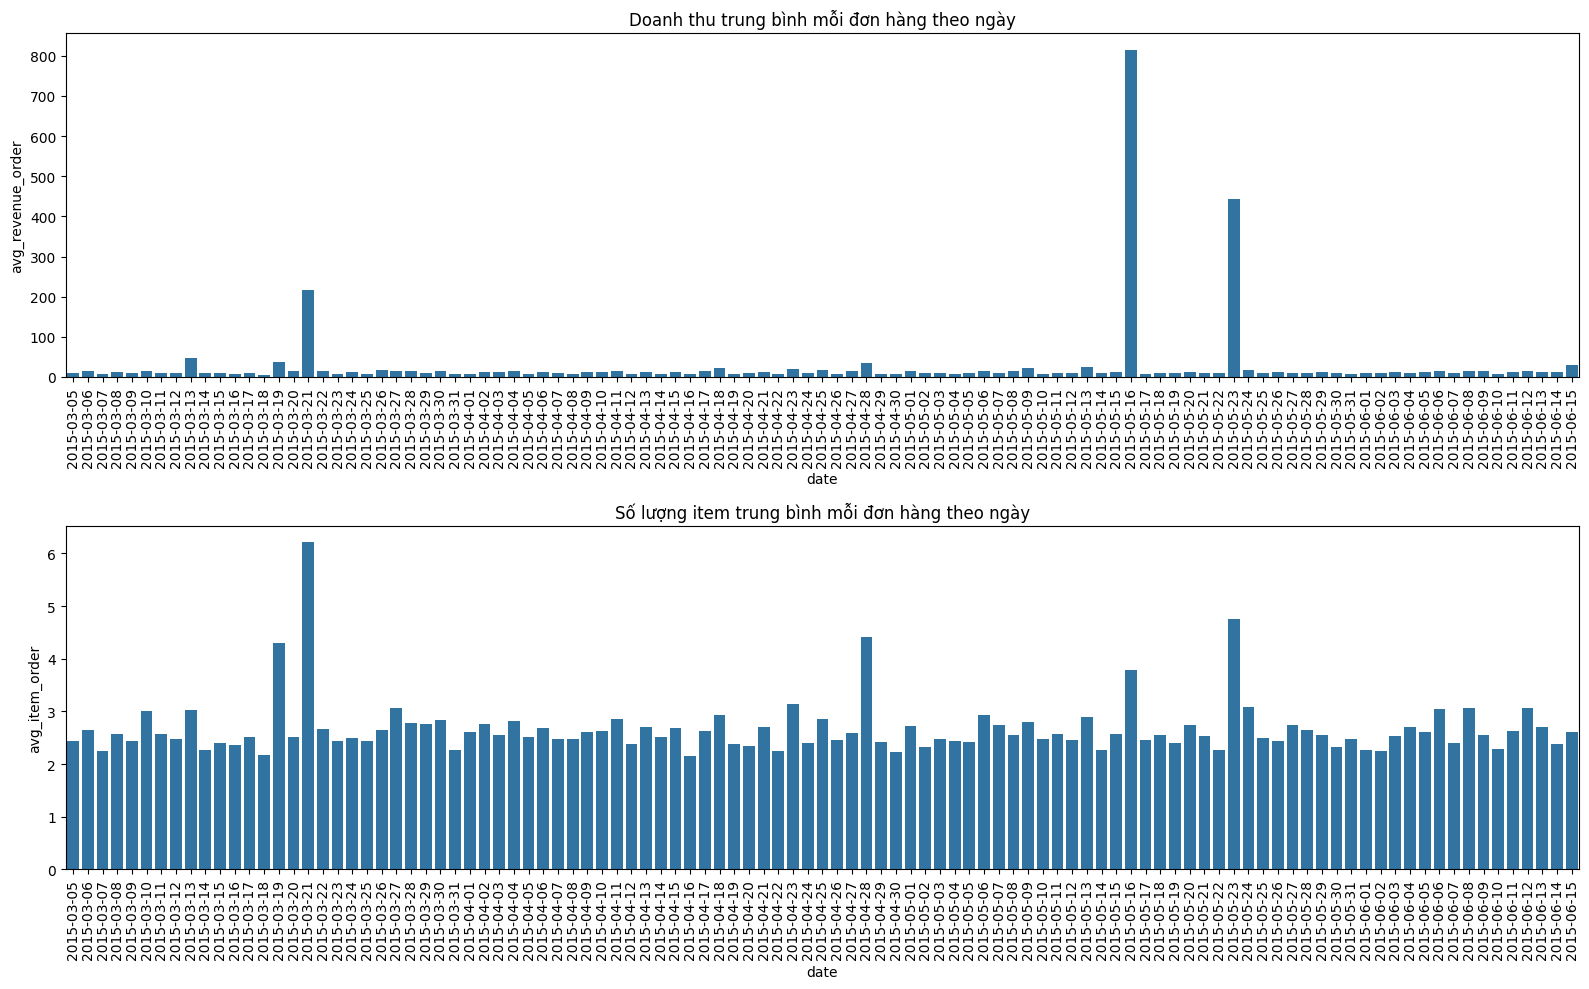

In [100]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(data=group_by_day_outliers,
             x='date',
             y='avg_revenue_order')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu trung bình mỗi đơn hàng theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=group_by_day_outliers,
             x='date',
             y='avg_item_order')
plt.xticks(rotation=90, ha='center')
plt.title("Số lượng item trung bình mỗi đơn hàng theo ngày")

plt.tight_layout()
plt.show()

## 2.3 Doanh thu từng cửa hàng

### 2.3.1 Doanh thu non_outliers

In [104]:
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week'],
      dtype='object')

In [105]:
group_by_day_store = non_outliers_quantity.groupby(['date', 'StoreNumber']).agg(
  total_order=('MD5KEY_ORDERSALE', 'nunique'),
  total_item=('Quantity', 'sum'),
  total_revenue=('SalesAmount', 'sum')).reset_index()

group_by_day_store['avg_item_order'] = group_by_day_store['total_item'] / group_by_day_store['total_order']
group_by_day_store['avg_revenue_order'] = group_by_day_store['total_revenue'] / group_by_day_store['total_order']

group_by_day_store

,date,StoreNumber,total_order,total_item,total_revenue,avg_item_order,avg_revenue_order
0,2015-03-05,12631,100,195,666.39,1.950000,6.663900
1,2015-03-05,46673,70,171,580.40,2.442857,8.291429
2,2015-03-06,12631,91,202,697.34,2.219780,7.663077
3,2015-03-06,20974,1,2,8.63,2.000000,8.630000
4,2015-03-06,46673,41,94,317.71,2.292683,7.749024
...,...,...,...,...,...,...,...
391,2015-06-14,46673,68,144,493.44,2.117647,7.256471
392,2015-06-15,4904,174,358,1205.85,2.057471,6.930172
393,2015-06-15,12631,109,223,751.74,2.045872,6.896697
394,2015-06-15,20974,96,214,782.33,2.229167,8.149271


In [106]:
store_number = group_by_day_store['StoreNumber'].unique()
store_number

array([12631, 46673, 20974,  4904])

#### 2.3.1.1 Doanh thu trung bình

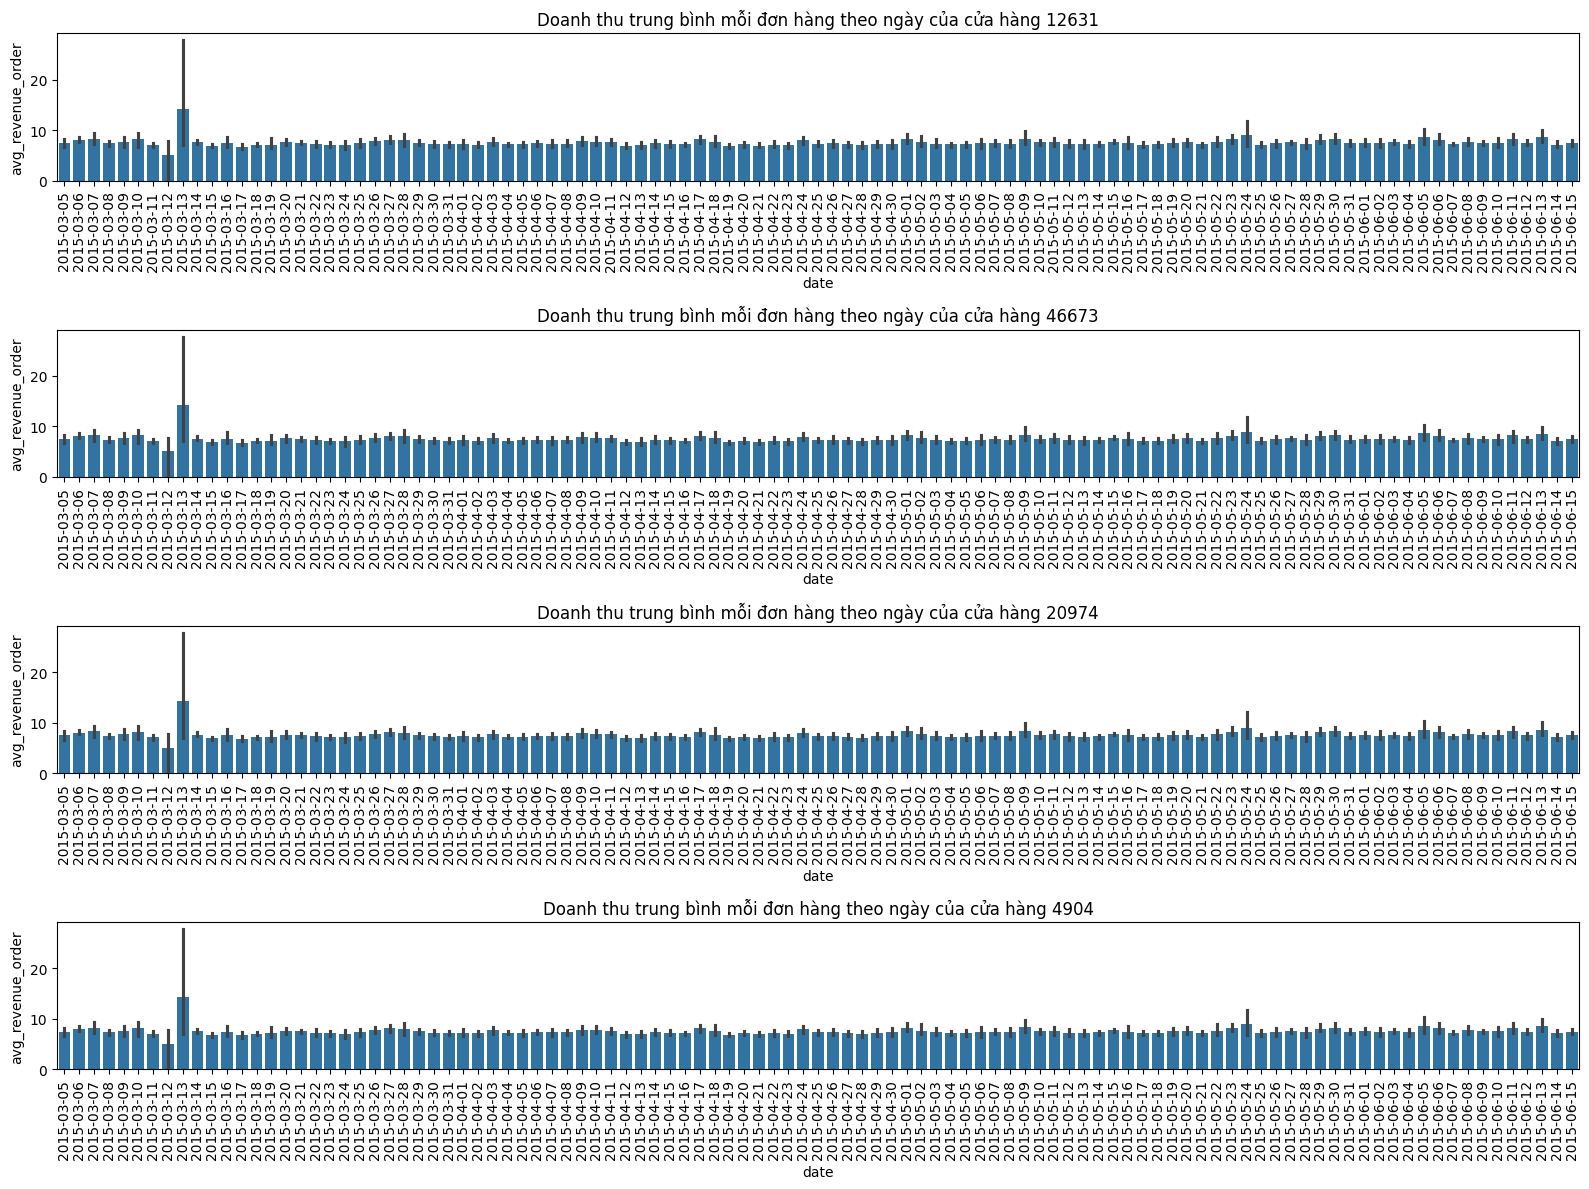

In [109]:
plt.figure(figsize=(16, 12))

for index, store in enumerate(store_number, start=1):
  plt.subplot(4, 1, index)
  sns.barplot(data=group_by_day_store,
              x='date',
              y='avg_revenue_order')
  plt.xticks(rotation=90, ha='center')
  plt.title(f"Doanh thu trung bình mỗi đơn hàng theo ngày của cửa hàng {store}")
  
plt.tight_layout()
plt.show()

#### 2.3.1.2 Đơn hàng trung bình

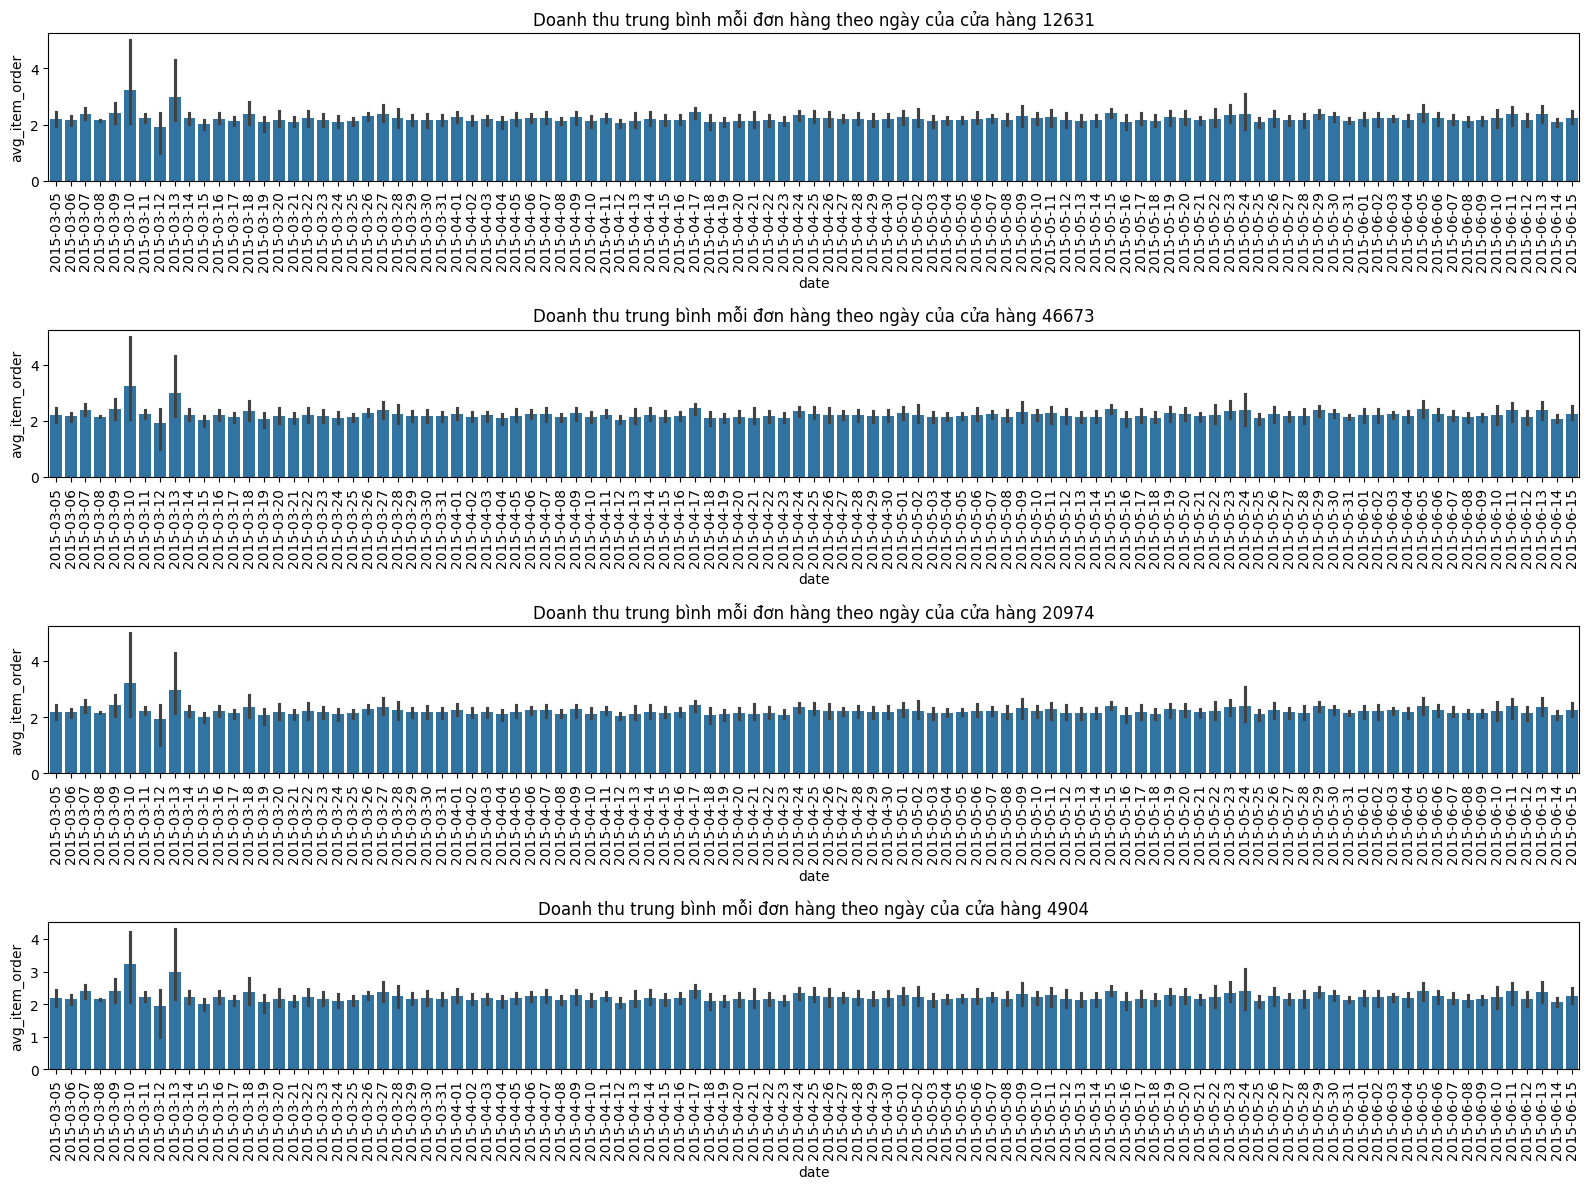

In [110]:
plt.figure(figsize=(16, 12))

for index, store in enumerate(store_number, start=1):
  plt.subplot(4, 1, index)
  sns.barplot(data=group_by_day_store,
              x='date',
              y='avg_item_order')
  plt.xticks(rotation=90, ha='center')
  plt.title(f"Doanh thu trung bình mỗi đơn hàng theo ngày của cửa hàng {store}")
  
plt.tight_layout()
plt.show()

### 2.3.2 Doanh thu outliers

In [115]:
group_by_day_store_outliers = outliers_quantity.groupby(['date', 'StoreNumber']).agg(
  total_order=('MD5KEY_ORDERSALE', 'nunique'),
  total_item=('Quantity', 'sum'),
  total_revenue=('SalesAmount', 'sum')).reset_index()

group_by_day_store_outliers['avg_item_order'] = group_by_day_store_outliers['total_item'] / group_by_day_store_outliers['total_order']
group_by_day_store_outliers['avg_revenue_order'] = group_by_day_store_outliers['total_revenue'] / group_by_day_store_outliers['total_order']

group_by_day_store_outliers

,date,StoreNumber,total_order,total_item,total_revenue,avg_item_order,avg_revenue_order
0,2015-03-05,12631,23,57,200.90,2.478261,8.734783
1,2015-03-05,46673,9,21,111.10,2.333333,12.344444
2,2015-03-06,12631,18,45,278.12,2.500000,15.451111
3,2015-03-06,46673,8,24,126.48,3.000000,15.810000
4,2015-03-07,12631,19,44,165.65,2.315789,8.718421
...,...,...,...,...,...,...,...
385,2015-06-14,46673,7,22,92.62,3.142857,13.231429
386,2015-06-15,4904,14,32,77.40,2.285714,5.528571
387,2015-06-15,12631,14,34,130.44,2.428571,9.317143
388,2015-06-15,20974,16,44,222.70,2.750000,13.918750


In [116]:
store_number_outliers = group_by_day_store['StoreNumber'].unique()
store_number_outliers

array([12631, 46673, 20974,  4904])

#### 2.3.2.1 Doanh thu trung bình

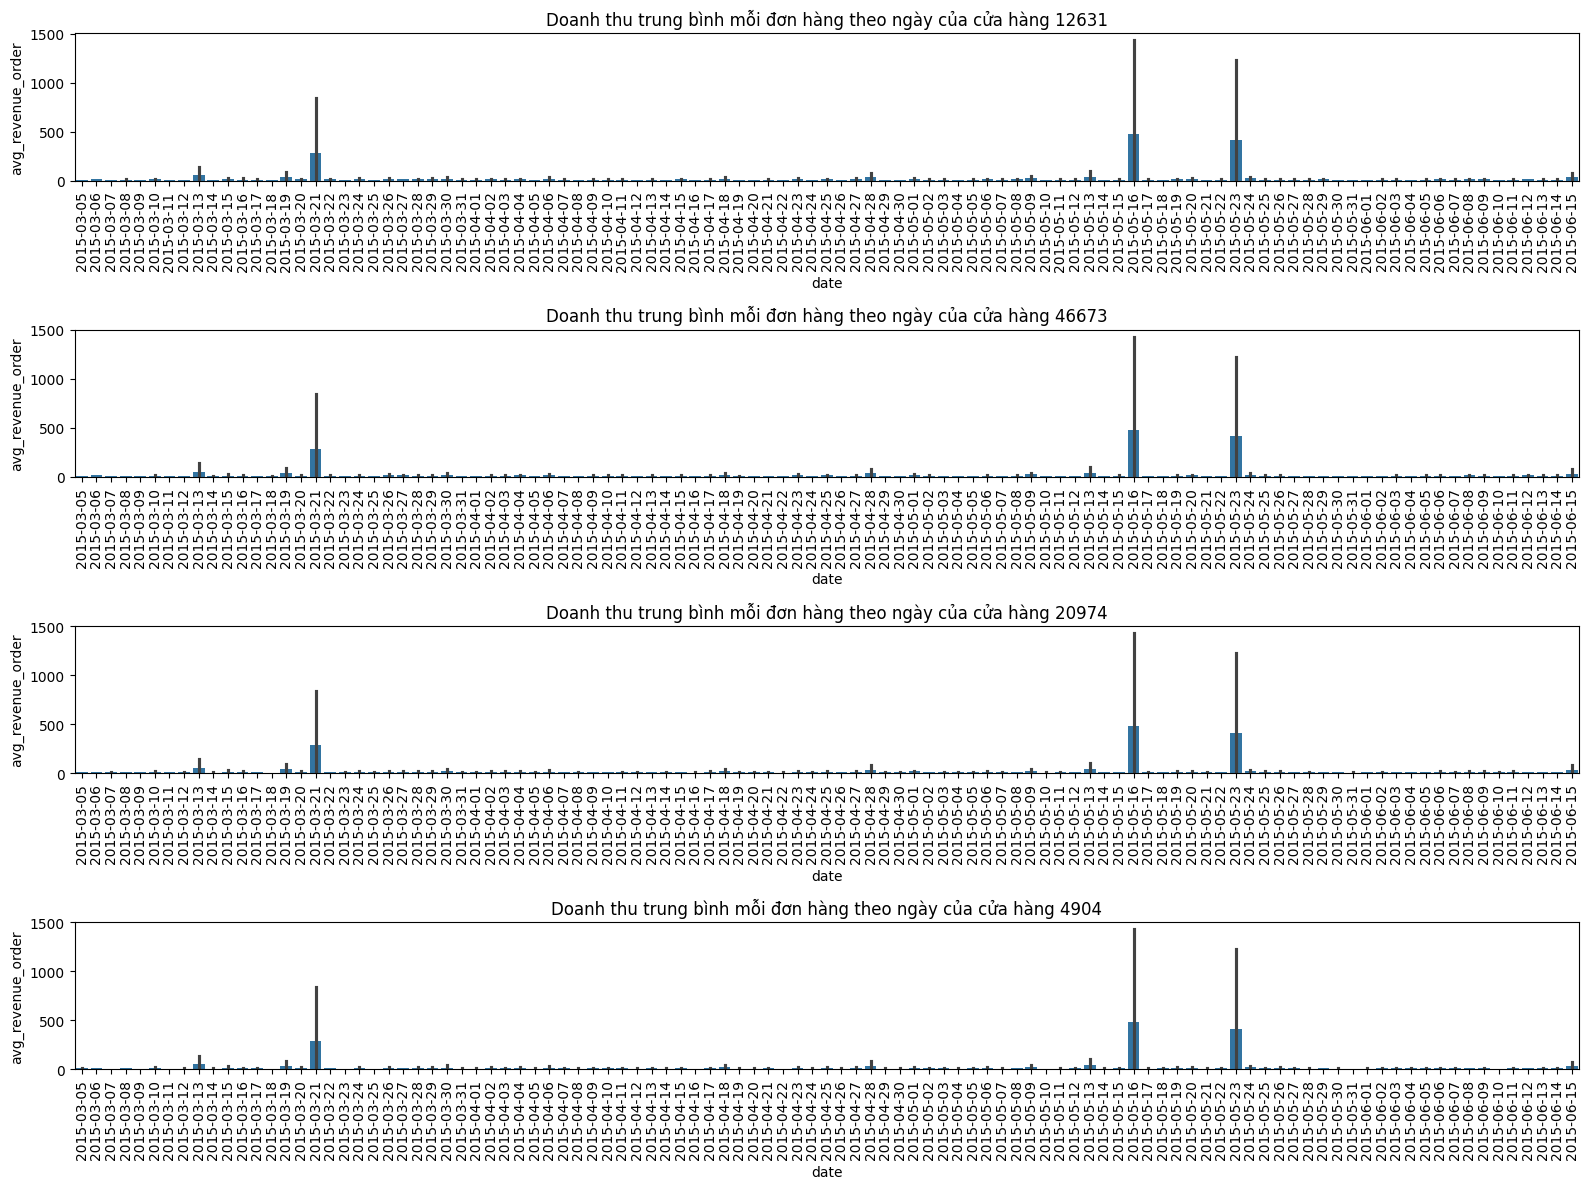

In [117]:
plt.figure(figsize=(16, 12))

for index, store in enumerate(store_number, start=1):
  plt.subplot(4, 1, index)
  sns.barplot(data=group_by_day_store_outliers,
              x='date',
              y='avg_revenue_order')
  plt.xticks(rotation=90, ha='center')
  plt.title(f"Doanh thu trung bình mỗi đơn hàng theo ngày của cửa hàng {store}")
  
plt.tight_layout()
plt.show()

#### 2.3.2.2 Đơn hàng trung bình

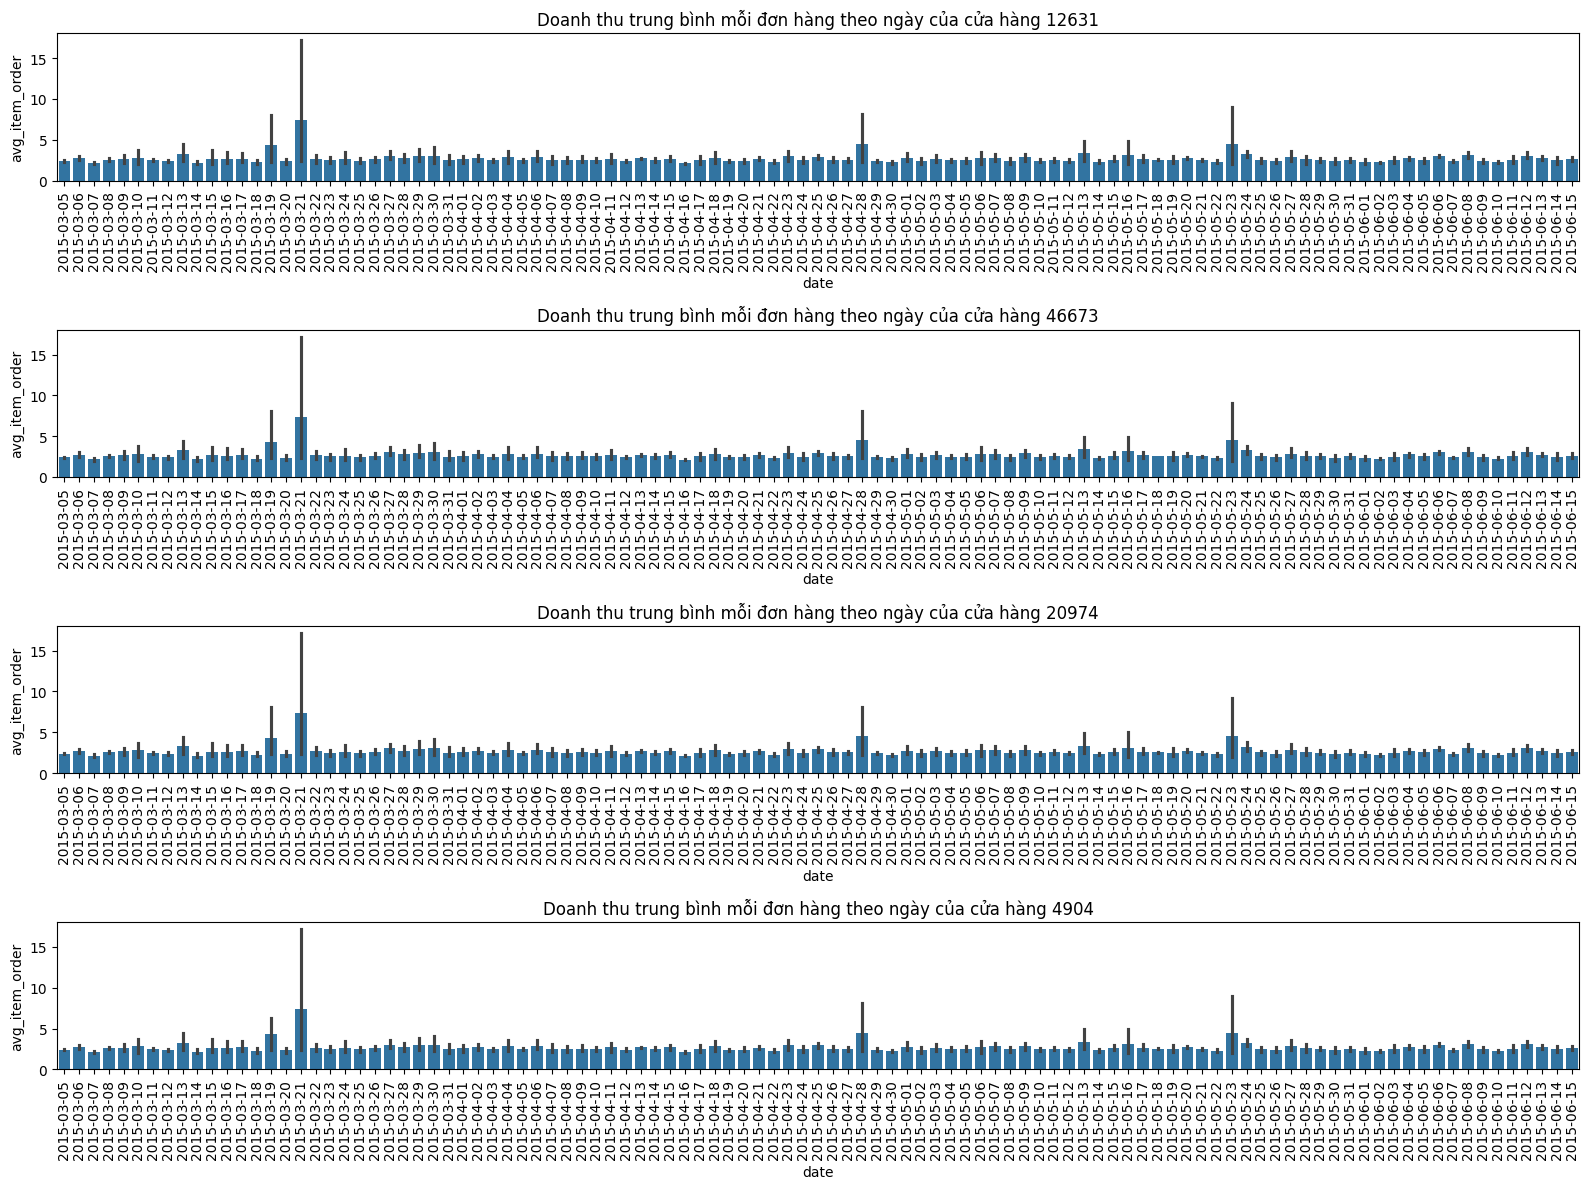

In [118]:
plt.figure(figsize=(16, 12))

for index, store in enumerate(store_number, start=1):
  plt.subplot(4, 1, index)
  sns.barplot(data=group_by_day_store_outliers,
              x='date',
              y='avg_item_order')
  plt.xticks(rotation=90, ha='center')
  plt.title(f"Doanh thu trung bình mỗi đơn hàng theo ngày của cửa hàng {store}")
  
plt.tight_layout()
plt.show()

## 2.4 Doanh thu trừ thuế

# 3. So sánh doanh thu từng cửa hàng
So sánh doanh thu của từng cửa hàng để xác định cửa hàng có doanh thu cao nhất và thấp nhất

# 4. Phân tích tác động của giảm giá
Phân tích tác động của việc giảm giá lên số lượng bán ra và doanh thu.

# 5. Tóm tắt
Tóm tắt các phát hiện chính từ phân tích và đề xuất các bước tiếp theo.